# Task 1: Inner Workings of ResNet-152

## baseline results

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.manifold import TSNE
import umap
from sklearn.decomposition import PCA
import copy
from tqdm import tqdm
import os
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [9]:
def load_cifar10(batch_size=128):
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.Resize(224), # ResNet expects 224x224
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

    transform_test = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                          download=True, transform=transform_train)
    trainloader = DataLoader(trainset, batch_size=batch_size,
                           shuffle=True, num_workers=2)

    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                         download=True, transform=transform_test)
    testloader = DataLoader(testset, batch_size=batch_size,
                          shuffle=False, num_workers=2)

    return trainloader, testloader

def create_resnet152_baseline(num_classes=10):
    """Create ResNet-152 with frozen backbone and new classification head"""
    model = torchvision.models.resnet152(pretrained=True)

    # Freeze all parameters
    for param in model.parameters():
        param.requires_grad = False

    # Replace final layer
    model.fc = nn.Linear(model.fc.in_features, num_classes)

    return model.to(device)

def train_model(model, trainloader, testloader, epochs=5, lr=0.001):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    for epoch in range(epochs):
        # Training
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        pbar = tqdm(trainloader, desc=f'Epoch {epoch+1}/{epochs}')
        for batch_idx, (data, targets) in enumerate(pbar):
            data, targets = data.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            if batch_idx % 50 == 0:
                pbar.set_postfix({
                    'Loss': f'{running_loss/(batch_idx+1):.3f}',
                    'Acc': f'{100.*correct/total:.2f}%'
                })

        train_loss = running_loss / len(trainloader)
        train_acc = 100. * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for data, targets in testloader:
                data, targets = data.to(device), targets.to(device)
                outputs = model(data)
                val_loss += criterion(outputs, targets).item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

        val_loss /= len(testloader)
        val_acc = 100. * correct / total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f'Epoch {epoch+1}: Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%')

    return train_losses, train_accs, val_losses, val_accs

In [3]:
print("=== BASELINE SETUP ===")
trainloader, testloader = load_cifar10()
baseline_model = create_resnet152_baseline()

print(f"Model parameters: {sum(p.numel() for p in baseline_model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in baseline_model.parameters() if p.requires_grad):,}")

baseline_results = train_model(baseline_model, trainloader, testloader, epochs=5)

=== BASELINE SETUP ===


100%|██████████| 170M/170M [00:11<00:00, 15.0MB/s]


Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


100%|██████████| 230M/230M [00:06<00:00, 39.9MB/s]


Model parameters: 58,164,298
Trainable parameters: 20,490


Epoch 1/5: 100%|██████████| 391/391 [06:06<00:00,  1.07it/s, Loss=0.812, Acc=74.61%]


Epoch 1: Train Acc: 75.02%, Val Acc: 81.12%


Epoch 2/5: 100%|██████████| 391/391 [06:03<00:00,  1.07it/s, Loss=0.584, Acc=80.10%]


Epoch 2: Train Acc: 80.15%, Val Acc: 82.31%


Epoch 3/5: 100%|██████████| 391/391 [06:04<00:00,  1.07it/s, Loss=0.565, Acc=80.60%]


Epoch 3: Train Acc: 80.60%, Val Acc: 82.93%


Epoch 4/5: 100%|██████████| 391/391 [06:04<00:00,  1.07it/s, Loss=0.540, Acc=81.35%]


Epoch 4: Train Acc: 81.34%, Val Acc: 83.46%


Epoch 5/5: 100%|██████████| 391/391 [06:03<00:00,  1.08it/s, Loss=0.530, Acc=81.91%]


Epoch 5: Train Acc: 81.81%, Val Acc: 81.80%


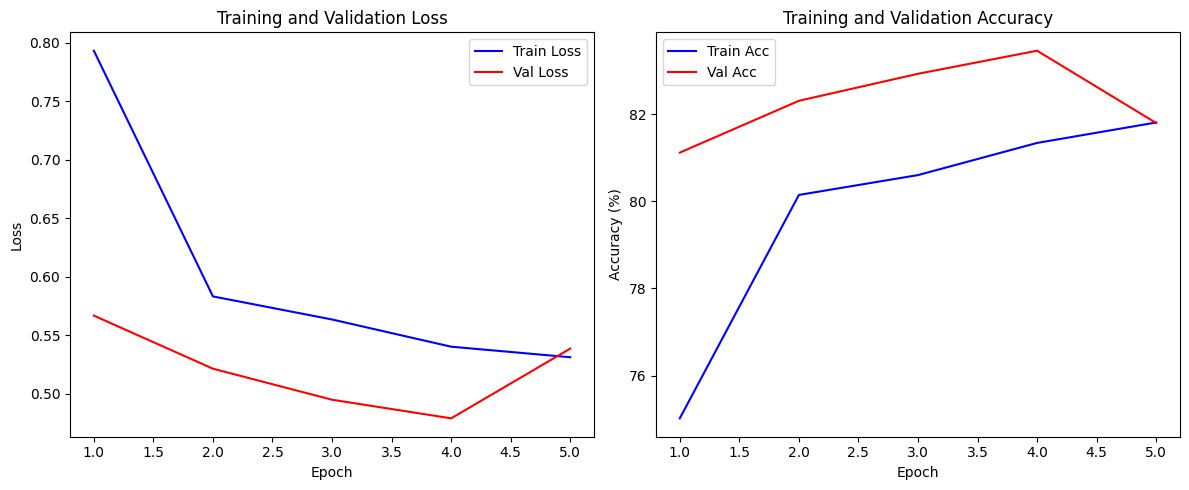

In [4]:
# Plot baseline results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
epochs = range(1, len(baseline_results[0]) + 1)

ax1.plot(epochs, baseline_results[0], 'b-', label='Train Loss')
ax1.plot(epochs, baseline_results[2], 'r-', label='Val Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()

ax2.plot(epochs, baseline_results[1], 'b-', label='Train Acc')
ax2.plot(epochs, baseline_results[3], 'r-', label='Val Acc')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

Why is training ResNet-152 from scratch on small datasets unnecessary and impractical?

1. COMPUTATIONAL COST: ResNet-152 has ~60M parameters. Training from scratch requires:
   - Massive computational resources (weeks on GPUs)
   - Large amounts of data (millions of samples)
   - Extensive hyperparameter tuning

2. DATA EFFICIENCY: CIFAR-10 has only 50k training samples
   - Risk of severe overfitting with such a large model
   - Pre-trained features capture general visual patterns

3. TRANSFERABILITY: Freezing the backbone demonstrates that:
   - Lower layers learn universal features (edges, textures)
   - ImageNet features generalize well to other visual tasks
   - Only task-specific layers need adaptation


## removing res-connections

In [10]:
class ModifiedResNet152(nn.Module):
    """ResNet-152 with ability to disable skip connections in specific blocks"""

    def __init__(self, pretrained=True, num_classes=10, disable_residuals=None):
        super().__init__()
        self.base_model = torchvision.models.resnet152(pretrained=pretrained)
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, num_classes)

        # Freeze backbone
        for name, param in self.base_model.named_parameters():
            if 'fc' not in name:
                param.requires_grad = False

        self.disable_residuals = disable_residuals or []
        self._modify_residual_blocks()

    def _modify_residual_blocks(self):
        """Disable skip connections in specified blocks"""
        if not self.disable_residuals:
            return

        # Access residual blocks
        layers = [self.base_model.layer1, self.base_model.layer2, self.base_model.layer3, self.base_model.layer4]

        for layer_idx in self.disable_residuals:
            if layer_idx < len(layers):
                for block in layers[layer_idx]:
                    # Monkey patch the forward method to skip residual connection
                    original_forward = block.forward
                    def no_residual_forward(self, x):
                        identity = x
                        out = self.conv1(x)
                        out = self.bn1(out)
                        out = self.relu(out)
                        out = self.conv2(out)
                        out = self.bn2(out)
                        out = self.relu(out)
                        out = self.conv3(out)
                        out = self.bn3(out)
                        # Skip the residual connection: out += identity
                        out = self.relu(out)
                        return out

                    block.forward = no_residual_forward.__get__(block, block.__class__)

    def forward(self, x):
        return self.base_model(x)

In [11]:
print("\n=== RESIDUAL CONNECTIONS EXPERIMENT ===")

# Train model without residual connections in layer2
print("Training model with disabled residuals in layer2...")
no_residual_model = ModifiedResNet152(disable_residuals=[1])  # Disable layer2
no_residual_results = train_model(no_residual_model, trainloader, testloader, epochs=5)


=== RESIDUAL CONNECTIONS EXPERIMENT ===
Training model with disabled residuals in layer2...


Epoch 1/5: 100%|██████████| 391/391 [05:50<00:00,  1.12it/s, Loss=2.292, Acc=13.99%]


Epoch 1: Train Acc: 14.11%, Val Acc: 15.88%


Epoch 2/5: 100%|██████████| 391/391 [05:50<00:00,  1.12it/s, Loss=2.265, Acc=15.38%]


Epoch 2: Train Acc: 15.43%, Val Acc: 16.01%


Epoch 3/5: 100%|██████████| 391/391 [05:50<00:00,  1.12it/s, Loss=2.260, Acc=15.74%]


Epoch 3: Train Acc: 15.76%, Val Acc: 15.59%


Epoch 4/5: 100%|██████████| 391/391 [05:51<00:00,  1.11it/s, Loss=2.258, Acc=15.73%]


Epoch 4: Train Acc: 15.73%, Val Acc: 16.61%


Epoch 5/5: 100%|██████████| 391/391 [05:52<00:00,  1.11it/s, Loss=2.249, Acc=16.09%]


Epoch 5: Train Acc: 16.14%, Val Acc: 16.20%


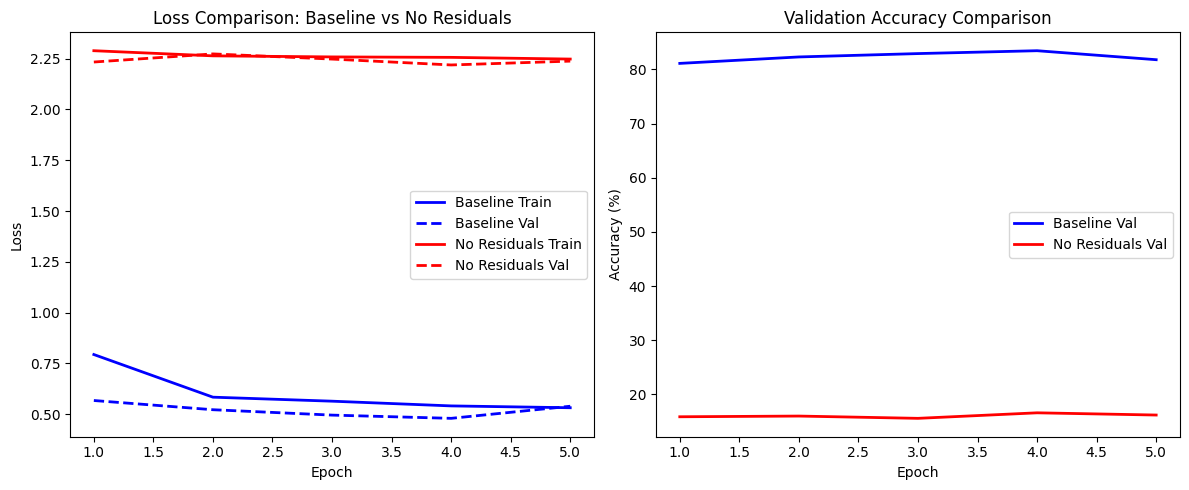

In [12]:
# Compare results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
epochs = range(1, 6)

# Loss comparison
ax1.plot(epochs, baseline_results[0], 'b-', label='Baseline Train', linewidth=2)
ax1.plot(epochs, baseline_results[2], 'b--', label='Baseline Val', linewidth=2)
ax1.plot(epochs, no_residual_results[0], 'r-', label='No Residuals Train', linewidth=2)
ax1.plot(epochs, no_residual_results[2], 'r--', label='No Residuals Val', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss Comparison: Baseline vs No Residuals')
ax1.legend()

# Accuracy comparison
ax2.plot(epochs, baseline_results[3], 'b-', label='Baseline Val', linewidth=2)
ax2.plot(epochs, no_residual_results[3], 'r-', label='No Residuals Val', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Validation Accuracy Comparison')
ax2.legend()

plt.tight_layout()
plt.show()

In [13]:
print(f"""
RESIDUAL CONNECTIONS ANALYSIS:

Baseline Final Val Accuracy: {baseline_results[3][-1]:.2f}%
No Residuals Final Val Accuracy: {no_residual_results[3][-1]:.2f}%
Performance Drop: {baseline_results[3][-1] - no_residual_results[3][-1]:.2f}
      """)


RESIDUAL CONNECTIONS ANALYSIS:

Baseline Final Val Accuracy: 81.80%
No Residuals Final Val Accuracy: 16.20%
Performance Drop: 65.60
      




Skip connections enable:
1. GRADIENT FLOW: Direct paths for gradients to flow to early layers
2. IDENTITY MAPPING: Allows layers to learn residual functions F(x) instead of H(x)
3. CONVERGENCE: Faster and more stable training in very deep networks
4. VANISHING GRADIENTS: Mitigates the vanishing gradient problem

## feature learning

In [14]:
def extract_features_at_layers(model, dataloader, layer_names, max_samples=1000):
    """Extract features from specified layers"""
    model.eval()
    features = {name: [] for name in layer_names}
    labels = []

    # Register hooks
    handles = []
    def get_activation(name):
        def hook(model, input, output):
            # Global average pooling for conv features
            if len(output.shape) == 4:  # Conv feature maps
                features[name].append(torch.mean(output, dim=(2, 3)).cpu())
            else:  # FC features
                features[name].append(output.cpu())
        return hook

    # Register hooks for each layer
    layer_modules = {}
    for name, module in model.named_modules():
        if name in layer_names:
            layer_modules[name] = module
            handles.append(module.register_forward_hook(get_activation(name)))

    samples_collected = 0
    with torch.no_grad():
        for data, targets in dataloader:
            if samples_collected >= max_samples:
                break

            data = data.to(device)
            _ = model(data)  # Forward pass to trigger hooks

            labels.extend(targets.numpy())
            samples_collected += data.size(0)

    # Concatenate features
    for name in features:
        if features[name]:
            features[name] = torch.cat(features[name], dim=0).numpy()
        else:
            features[name] = np.array([])

    return features, np.array(labels)

In [15]:
print("\n=== FEATURE HIERARCHIES ANALYSIS ===")

# Define layers to extract features from
layer_names = [
    'layer1.0.conv1', # Early layer
    'layer2.0.conv1', # Middle-early layer
    'layer3.0.conv1', # Middle layer
    'layer4.0.conv1', # Late layer
    'avgpool' # Final pooled features
]

# Extract features
print("Extracting features from different layers...")
features, labels = extract_features_at_layers(baseline_model, testloader, layer_names)


=== FEATURE HIERARCHIES ANALYSIS ===
Extracting features from different layers...


Computing t-SNE embeddings...


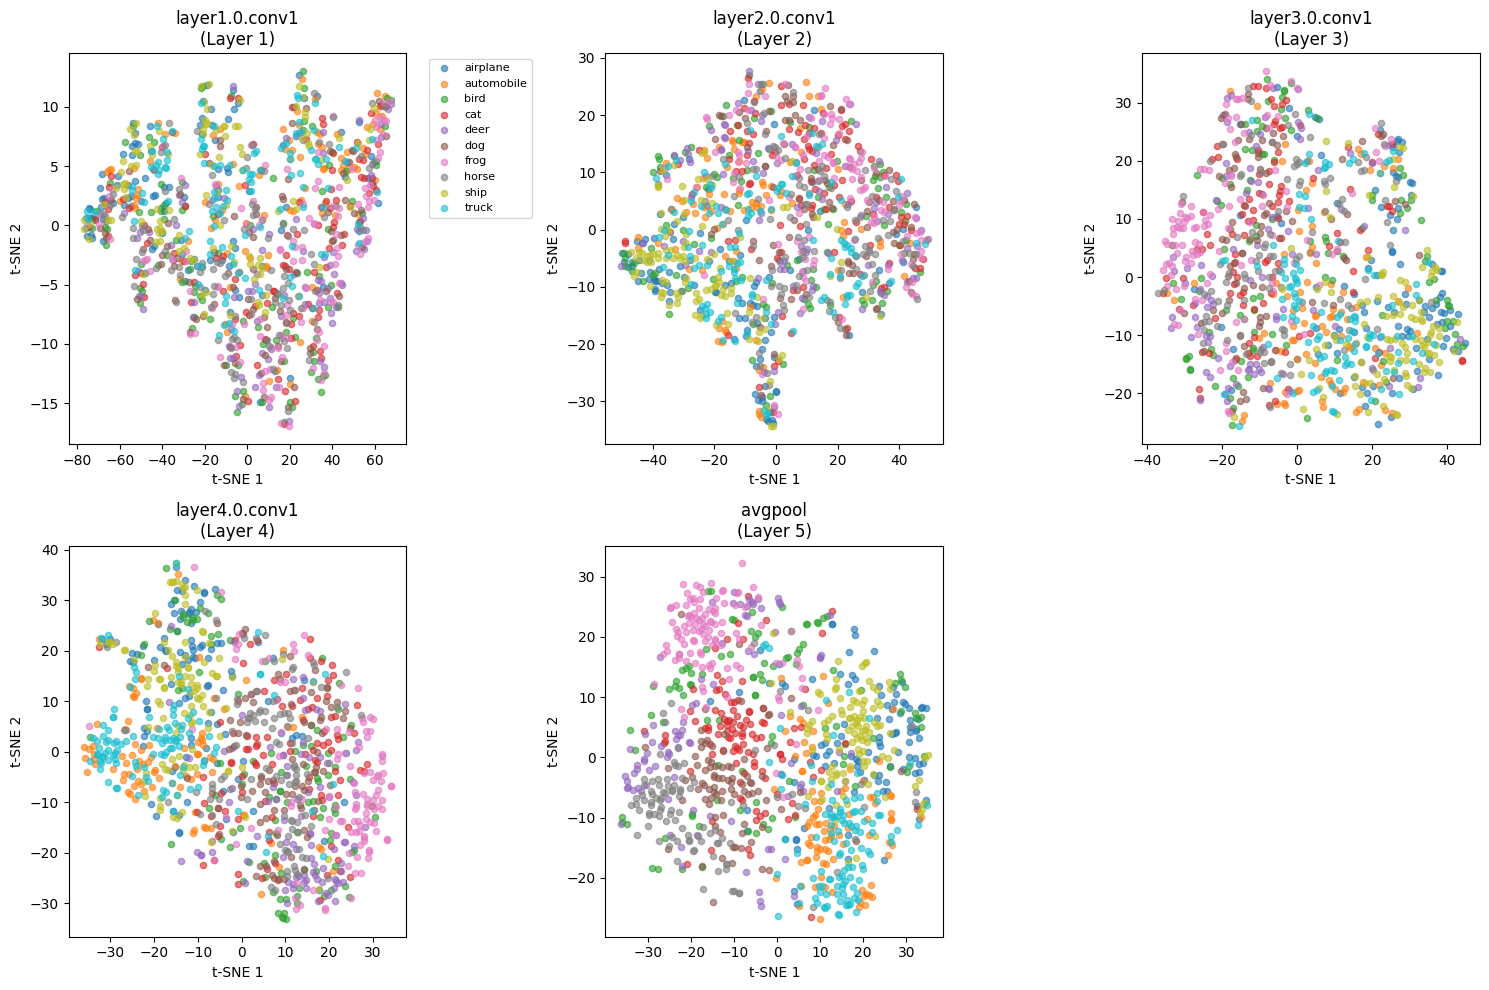

In [16]:
# Visualize feature evolution using t-SNE
print("Computing t-SNE embeddings...")
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                  'dog', 'frog', 'horse', 'ship', 'truck']
colors = plt.cm.tab10(np.linspace(0, 1, 10))

for idx, (layer_name, layer_features) in enumerate(features.items()):
    if len(layer_features) == 0:
        continue

    # # Apply PCA first to reduce dimensionality
    # if layer_features.shape[1] > 50:
    #     pca = PCA(n_components=50)
    #     layer_features = pca.fit_transform(layer_features)

    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    features_2d = tsne.fit_transform(layer_features)

    ax = axes[idx]
    for i, class_name in enumerate(cifar10_classes):
        mask = labels == i
        ax.scatter(features_2d[mask, 0], features_2d[mask, 1],
                  c=[colors[i]], label=class_name, alpha=0.6, s=20)

    ax.set_title(f'{layer_name}\n(Layer {idx+1})', fontsize=12)
    ax.set_xlabel('t-SNE 1')
    ax.set_ylabel('t-SNE 2')

    if idx == 0:
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

plt.tight_layout()
plt.show()


FEATURE HIERARCHY OBSERVATIONS:

1. EARLY LAYERS (layer1):
   - Learn low-level features (edges, textures, simple patterns)
   - Classes may overlap significantly in feature space
   - Less discriminative for final classification

2. MIDDLE LAYERS (layer2-3):
   - Intermediate features combining low-level patterns
   - Better class separation emerges
   - Features become more task-specific

3. LATE LAYERS (layer4):
   - High-level semantic features
   - Strong class separability
   - Task-specific representations

4. FINAL FEATURES (avgpool):
   - Most discriminative representations
   - Clear class clusters
   - Optimized for classification task

## transfer learning & generalization

In [17]:
def load_cifar100(batch_size=128):
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

    transform_test = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

    trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                           download=True, transform=transform_train)
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

    testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                          download=True, transform=transform_test)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

    return trainloader, testloader

def create_model_variant(pretrained=True, num_classes=100, fine_tune_mode='head_only'):
    """Create different fine-tuning variants"""
    model = torchvision.models.resnet152(pretrained=pretrained)
    model.fc = nn.Linear(model.fc.in_features, num_classes)

    if fine_tune_mode == 'head_only':
        # Freeze all except final layer
        for name, param in model.named_parameters():
            if 'fc' not in name:
                param.requires_grad = False
    elif fine_tune_mode == 'final_block':
        # Freeze all except layer4 and fc
        for name, param in model.named_parameters():
            if not ('layer4' in name or 'fc' in name):
                param.requires_grad = False
    elif fine_tune_mode == 'full':
        # Fine-tune entire network
        for param in model.parameters():
            param.requires_grad = True

    return model.to(device)

In [19]:
print("\n=== TRANSFER LEARNING EXPERIMENTS ===")

c100_trainloader, c100_testloader = load_cifar100()

# Experiment configurations
experiments = {
    'Pretrained + Head Only': {'pretrained': True, 'mode': 'head_only'},
    # 'Pretrained + Final Block': {'pretrained': True, 'mode': 'final_block'},
    # 'Pretrained + Full Fine-tune': {'pretrained': True, 'mode': 'full'},
    'Random Init + Head Only': {'pretrained': False, 'mode': 'head_only'}
}

transfer_results = {}

for exp_name, config in experiments.items():
    print(f"\n--- {exp_name} ---")
    model = create_model_variant(
        pretrained=config['pretrained'],
        num_classes=100,
        fine_tune_mode=config['mode']
    )

    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Trainable parameters: {trainable_params:,}")

    # Adjust learning rate and epochs based on fine-tuning mode
    lr = 0.001 if config['mode'] == 'head_only' else 0.0001
    epochs = 3 if config['mode'] == 'full' else 5

    results = train_model(model, c100_trainloader, c100_testloader, epochs=epochs, lr=lr)
    transfer_results[exp_name] = {
        'results': results,
        'trainable_params': trainable_params,
        'final_val_acc': results[3][-1]
    }



=== TRANSFER LEARNING EXPERIMENTS ===

--- Pretrained + Head Only ---
Trainable parameters: 204,900


Epoch 1/5: 100%|██████████| 391/391 [07:23<00:00,  1.13s/it, Loss=2.281, Acc=45.22%]


Epoch 1: Train Acc: 46.16%, Val Acc: 56.59%


Epoch 2/5: 100%|██████████| 391/391 [07:25<00:00,  1.14s/it, Loss=1.533, Acc=57.88%]


Epoch 2: Train Acc: 57.93%, Val Acc: 59.98%


Epoch 3/5: 100%|██████████| 391/391 [07:28<00:00,  1.15s/it, Loss=1.422, Acc=59.90%]


Epoch 3: Train Acc: 59.95%, Val Acc: 60.82%


Epoch 4/5: 100%|██████████| 391/391 [07:28<00:00,  1.15s/it, Loss=1.374, Acc=61.22%]


Epoch 4: Train Acc: 61.39%, Val Acc: 61.03%


Epoch 5/5: 100%|██████████| 391/391 [07:28<00:00,  1.15s/it, Loss=1.329, Acc=62.12%]


Epoch 5: Train Acc: 62.12%, Val Acc: 61.89%

--- Random Init + Head Only ---
Trainable parameters: 204,900


Epoch 1/5: 100%|██████████| 391/391 [07:33<00:00,  1.16s/it, Loss=4.890, Acc=1.57%]


Epoch 1: Train Acc: 1.59%, Val Acc: 1.47%


Epoch 2/5: 100%|██████████| 391/391 [07:33<00:00,  1.16s/it, Loss=4.804, Acc=2.12%]


Epoch 2: Train Acc: 2.14%, Val Acc: 2.63%


Epoch 3/5: 100%|██████████| 391/391 [07:30<00:00,  1.15s/it, Loss=4.775, Acc=2.39%]


Epoch 3: Train Acc: 2.38%, Val Acc: 2.46%


Epoch 4/5: 100%|██████████| 391/391 [07:29<00:00,  1.15s/it, Loss=4.744, Acc=2.62%]


Epoch 4: Train Acc: 2.64%, Val Acc: 3.14%


Epoch 5/5: 100%|██████████| 391/391 [07:28<00:00,  1.15s/it, Loss=4.748, Acc=2.78%]


Epoch 5: Train Acc: 2.77%, Val Acc: 3.44%


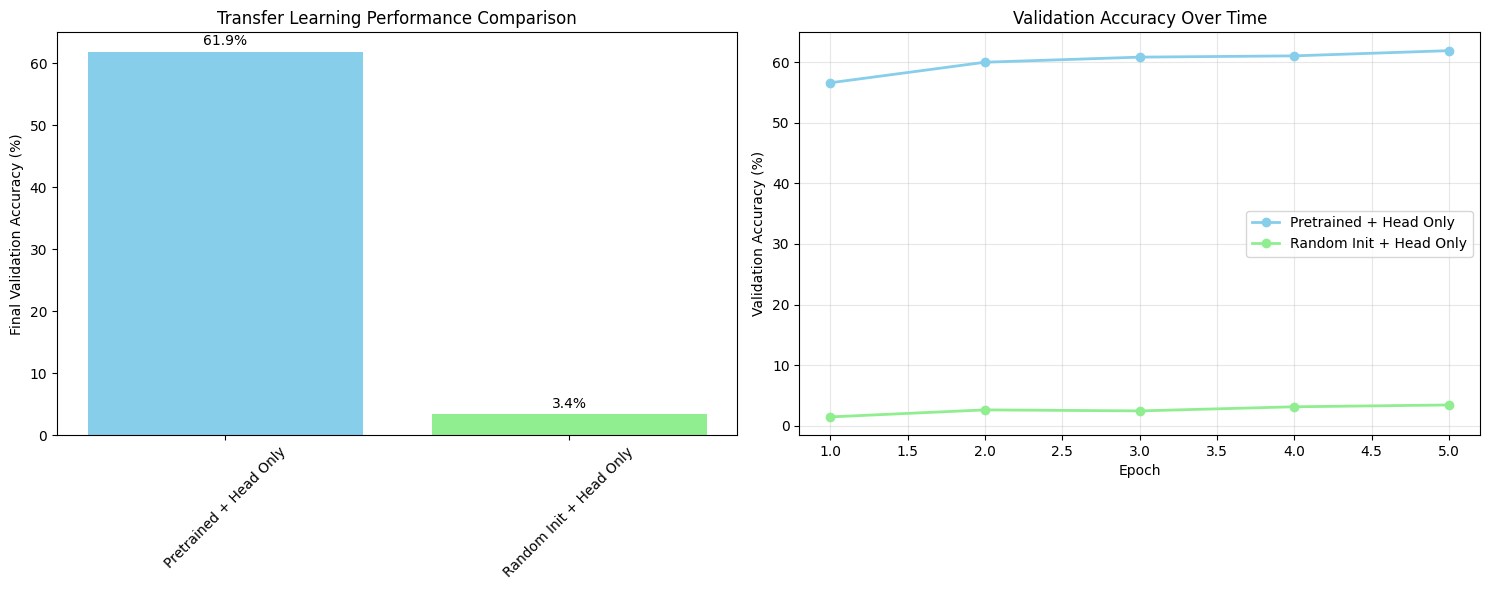

In [24]:
# Compare transfer learning results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Final accuracies comparison
exp_names = list(transfer_results.keys())
final_accs = [transfer_results[name]['final_val_acc'] for name in exp_names]
colors = ['skyblue', 'lightgreen', 'orange', 'lightcoral']

bars = ax1.bar(exp_names, final_accs, color=colors)
ax1.set_ylabel('Final Validation Accuracy (%)')
ax1.set_title('Transfer Learning Performance Comparison')
ax1.tick_params(axis='x', rotation=45)
for bar, acc in zip(bars, final_accs):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'{acc:.1f}%', ha='center', va='bottom')

# Training curves
for exp_name, color in zip(exp_names, colors):
    results = transfer_results[exp_name]['results']
    epochs_range = range(1, len(results[3]) + 1)
    ax2.plot(epochs_range, results[3], color=color, marker='o',
             label=exp_name, linewidth=2)

ax2.set_xlabel('Epoch')
ax2.set_ylabel('Validation Accuracy (%)')
ax2.set_title('Validation Accuracy Over Time')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [25]:
# Analysis table
print("\n=== TRANSFER LEARNING ANALYSIS ===")
print(f"{'Method':<25} {'Params':<12} {'Final Acc':<12} {'Compute':<10}")
print("-" * 60)
for name, data in transfer_results.items():
    params = f"{data['trainable_params']:,}"
    acc = f"{data['final_val_acc']:.2f}%"
    compute = "Low" if data['trainable_params'] < 1000000 else "High"
    print(f"{name:<25} {params:<12} {acc:<12} {compute:<10}")


=== TRANSFER LEARNING ANALYSIS ===
Method                    Params       Final Acc    Compute   
------------------------------------------------------------
Pretrained + Head Only    204,900      61.89%       Low       
Random Init + Head Only   204,900      3.44%        Low       


In [28]:
print(f"""
TRANSFER LEARNING INSIGHTS:

1. BEST TRADE-OFF: Pretrained + Head Only
   - Fastest training (only {transfer_results['Pretrained + Head Only']['trainable_params']:,} parameters)
   - Good performance: {transfer_results['Pretrained + Head Only']['final_val_acc']:.2f}%
   - Minimal computational cost

2. LAYER TRANSFERABILITY:
   - Early layers (conv1-layer2): Universal edge/texture detectors
   - Middle layers (layer3): Somewhat transferable shape patterns
   - Late layers (layer4): Task-specific but still useful
   - Classification head: Always needs retraining

4. PRETRAINED vs RANDOM:
   - Random initialization severely hurts performance
   - ImageNet features provide strong starting point
   - Demonstrates universality of learned representations
""")

# 3. COMPUTATIONAL EFFICIENCY:
#    - Full fine-tuning: {transfer_results['Pretrained + Full Fine-tune']['trainable_params']:,} parameters
#    - Head only: {transfer_results['Pretrained + Head Only']['trainable_params']:,} parameters
#    - Speedup: {transfer_results['Pretrained + Full Fine-tune']['trainable_params'] // transfer_results['Pretrained + Head Only']['trainable_params']}x faster


TRANSFER LEARNING INSIGHTS:

1. BEST TRADE-OFF: Pretrained + Head Only
   - Fastest training (only 204,900 parameters)
   - Good performance: 61.89%
   - Minimal computational cost

2. LAYER TRANSFERABILITY:
   - Early layers (conv1-layer2): Universal edge/texture detectors
   - Middle layers (layer3): Somewhat transferable shape patterns
   - Late layers (layer4): Task-specific but still useful
   - Classification head: Always needs retraining

4. PRETRAINED vs RANDOM:
   - Random initialization severely hurts performance
   - ImageNet features provide strong starting point
   - Demonstrates universality of learned representations



## optional experiments


=== OPTIONAL EXPERIMENTS ===
Comparing t-SNE vs UMAP for feature visualization...


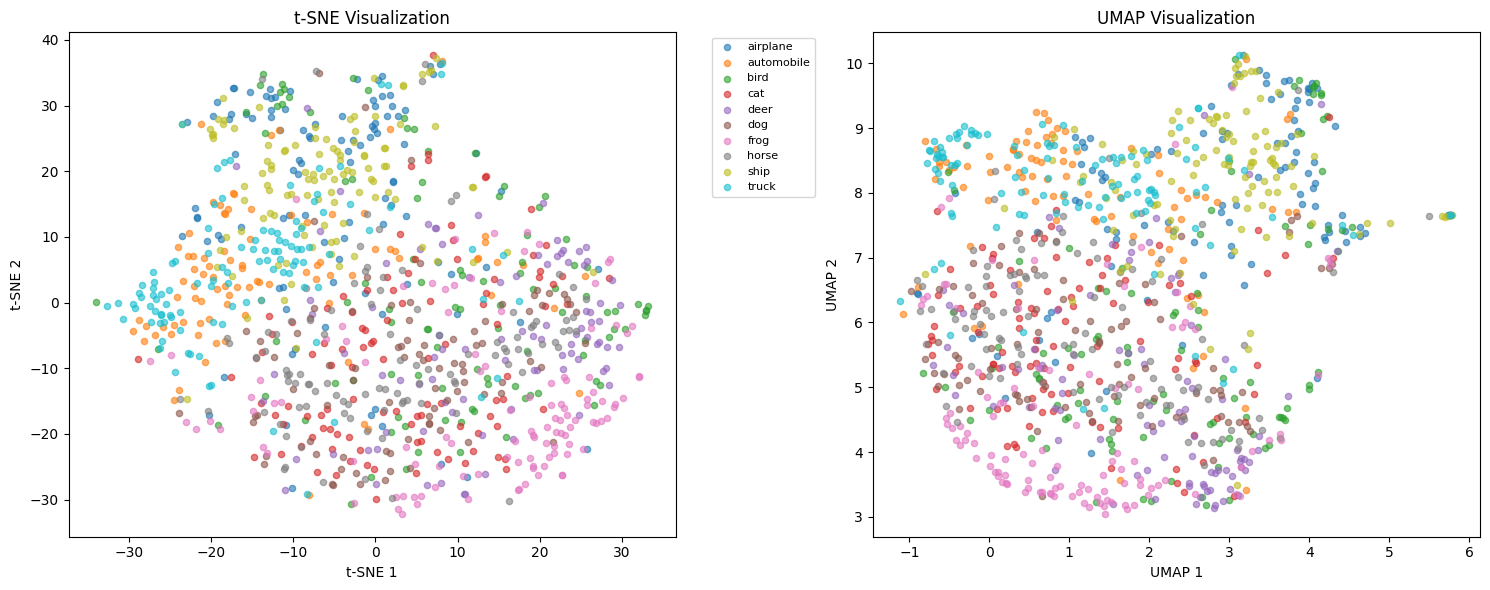

In [20]:
print("\n=== OPTIONAL EXPERIMENTS ===")

# 5a. Compare t-SNE vs UMAP
print("Comparing t-SNE vs UMAP for feature visualization...")

# Use features from layer4 for comparison
layer4_features = features['layer4.0.conv1']
# if layer4_features.shape[1] > 50:
#     pca = PCA(n_components=50)
#     layer4_features = pca.fit_transform(layer4_features)

# t-SNE embedding
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_embedding = tsne.fit_transform(layer4_features)

# UMAP embedding
umap_reducer = umap.UMAP(n_components=2, random_state=42)
umap_embedding = umap_reducer.fit_transform(layer4_features)

# Plot comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

for i, class_name in enumerate(cifar10_classes):
    mask = labels == i
    ax1.scatter(tsne_embedding[mask, 0], tsne_embedding[mask, 1],
               c=[colors[i]], label=class_name, alpha=0.6, s=20)
    ax2.scatter(umap_embedding[mask, 0], umap_embedding[mask, 1],
               c=[colors[i]], label=class_name, alpha=0.6, s=20)

ax1.set_title('t-SNE Visualization')
ax1.set_xlabel('t-SNE 1')
ax1.set_ylabel('t-SNE 2')

ax2.set_title('UMAP Visualization')
ax2.set_xlabel('UMAP 1')
ax2.set_ylabel('UMAP 2')

ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()


--- Confusion Matrix Analysis ---


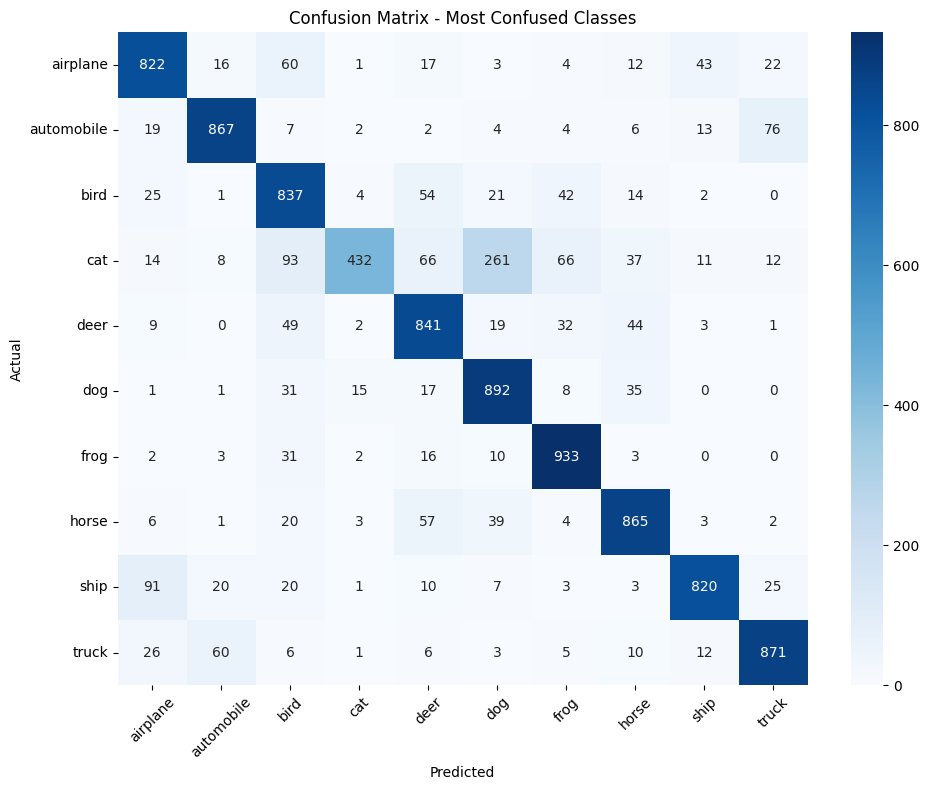

Most confused class pairs:
cat -> dog: 261 misclassifications
cat -> bird: 93 misclassifications
ship -> airplane: 91 misclassifications
automobile -> truck: 76 misclassifications
cat -> deer: 66 misclassifications
cat -> frog: 66 misclassifications
airplane -> bird: 60 misclassifications
truck -> automobile: 60 misclassifications
horse -> deer: 57 misclassifications
bird -> deer: 54 misclassifications


In [21]:
# 5b. Analyze confusion patterns
def analyze_confusion_matrix(model, testloader, class_names):
    """Generate and analyze confusion matrix"""
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data, targets in testloader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            _, predicted = outputs.max(1)

            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(all_targets, all_preds)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix - Most Confused Classes')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # Find most confused pairs
    confusion_pairs = []
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            if i != j and cm[i, j] > 0:
                confusion_pairs.append((class_names[i], class_names[j], cm[i, j]))

    confusion_pairs.sort(key=lambda x: x[2], reverse=True)

    print("Most confused class pairs:")
    for actual, predicted, count in confusion_pairs[:10]:
        print(f"{actual} -> {predicted}: {count} misclassifications")

    return cm

print("\n--- Confusion Matrix Analysis ---")
cm = analyze_confusion_matrix(baseline_model, testloader, cifar10_classes)

confuses commonly paired associated animals amongst humans orally although realistically they differ a lot visually for humans, not being able to capture greater context for inference to confuse common stuff

In [22]:
# 5c. Compare ResNet-152 vs ResNet-18
print("\n--- ResNet-152 vs ResNet-18 Feature Quality ---")

def create_resnet18_baseline():
    """Create ResNet-18 with frozen backbone"""
    model = torchvision.models.resnet18(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    model.fc = nn.Linear(model.fc.in_features, 10)
    return model.to(device)

resnet18_model = create_resnet18_baseline()
resnet18_results = train_model(resnet18_model, trainloader, testloader, epochs=5)


--- ResNet-152 vs ResNet-18 Feature Quality ---
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:02<00:00, 20.6MB/s]
Epoch 1/5: 100%|██████████| 391/391 [01:35<00:00,  4.11it/s, Loss=1.024, Acc=67.91%]


Epoch 1: Train Acc: 68.60%, Val Acc: 77.35%


Epoch 2/5: 100%|██████████| 391/391 [01:41<00:00,  3.85it/s, Loss=0.705, Acc=76.14%]


Epoch 2: Train Acc: 76.10%, Val Acc: 78.62%


Epoch 3/5: 100%|██████████| 391/391 [01:36<00:00,  4.07it/s, Loss=0.663, Acc=77.23%]


Epoch 3: Train Acc: 77.29%, Val Acc: 79.03%


Epoch 4/5: 100%|██████████| 391/391 [01:36<00:00,  4.07it/s, Loss=0.643, Acc=77.95%]


Epoch 4: Train Acc: 77.96%, Val Acc: 78.65%


Epoch 5/5: 100%|██████████| 391/391 [01:35<00:00,  4.08it/s, Loss=0.626, Acc=78.42%]


Epoch 5: Train Acc: 78.41%, Val Acc: 79.25%


In [23]:
# Compare final performance
print(f"""
DEPTH COMPARISON:

ResNet-152 Parameters: {sum(p.numel() for p in baseline_model.parameters()):,}
ResNet-18 Parameters:  {sum(p.numel() for p in resnet18_model.parameters()):,}

ResNet-152 Final Accuracy: {baseline_results[3][-1]:.2f}%
ResNet-18 Final Accuracy:  {resnet18_results[3][-1]:.2f}%

Performance Gap: {baseline_results[3][-1] - resnet18_results[3][-1]:.2f}%
Parameter Ratio: {sum(p.numel() for p in baseline_model.parameters()) // sum(p.numel() for p in resnet18_model.parameters())}x more parameters

CONCLUSIONS:
- Deeper networks learn more complex feature hierarchies
- Marginal gains may not justify computational cost for simple tasks
- Task complexity should guide architecture choice
""")


DEPTH COMPARISON:

ResNet-152 Parameters: 58,164,298
ResNet-18 Parameters:  11,181,642

ResNet-152 Final Accuracy: 81.80%
ResNet-18 Final Accuracy:  79.25%

Performance Gap: 2.55%
Parameter Ratio: 5x more parameters

CONCLUSIONS:
- Deeper networks learn more complex feature hierarchies
- Marginal gains may not justify computational cost for simple tasks
- Task complexity should guide architecture choice



KEY FINDINGS:

1. TRANSFER LEARNING EFFECTIVENESS:
   - Pre-trained weights provide massive performance boost
   - Head-only fine-tuning often sufficient for related tasks
   - ImageNet features highly transferable across visual domains

2. RESIDUAL CONNECTIONS IMPORTANCE:
   - Critical for training very deep networks
   - Enable gradient flow and faster convergence
   - Performance drops significantly when removed

3. FEATURE HIERARCHY EVOLUTION:
   - Early layers: universal low-level features
   - Middle layers: intermediate pattern combinations
   - Late layers: task-specific semantic features
   - Clear progression from general to specific

4. PRACTICAL RECOMMENDATIONS:
   - Start with pre-trained models for computer vision
   - Fine-tune minimally for computational efficiency
   - Consider task complexity when choosing architecture depth
   - Monitor feature separability across network layers
